In [3]:
from read_data import read_data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_df, test_df, test_labels_df = read_data("data/")

# ignore test values with -1 labels
test_df_usable = test_df.loc[test_labels_df['toxic'] != -1]
test_labels_df_usable = test_labels_df.loc[test_labels_df['toxic'] != -1]

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [3]:
def visualize_labels(df, label_cols):
    # Melt the dataframe into long format
    label_df = df[label_cols].melt(var_name='label_type', value_name='value')

    # plot data
    ax = sns.displot(data=label_df, x='label_type', hue='value', multiple="dodge", shrink=0.8, palette='Set2')
    ax.set_xticklabels(rotation=45, ha="right")
    ax.axes[0, 0].set_xlabel(None)
    plt.title('Label Distribution')
    plt.tight_layout()
    plt.show()

def count_positive_labels(df, label_cols):
    new_df = pd.DataFrame()
    new_df['has_label'] = (df[label_cols].sum(axis=1) > 0).astype(int)
    print(new_df['has_label'].value_counts())

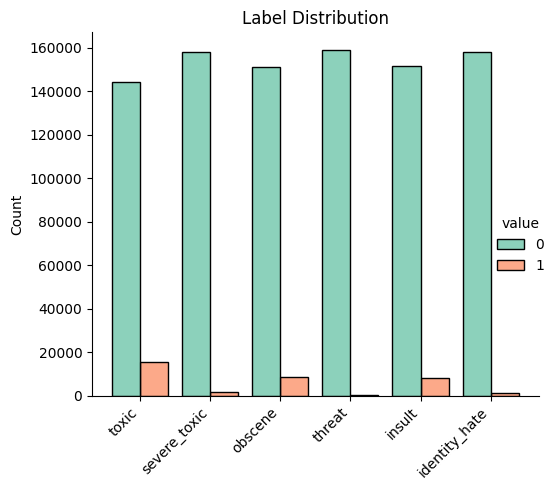

In [4]:
# plot the labels to visualize positive vs negative samples
visualize_labels(train_df, label_cols)

In [5]:
# check how many rows have at least one positive label
count_positive_labels(train_df, label_cols)
count_positive_labels(test_labels_df_usable, label_cols)

has_label
0    143346
1     16225
Name: count, dtype: int64
has_label
0    57735
1     6243
Name: count, dtype: int64


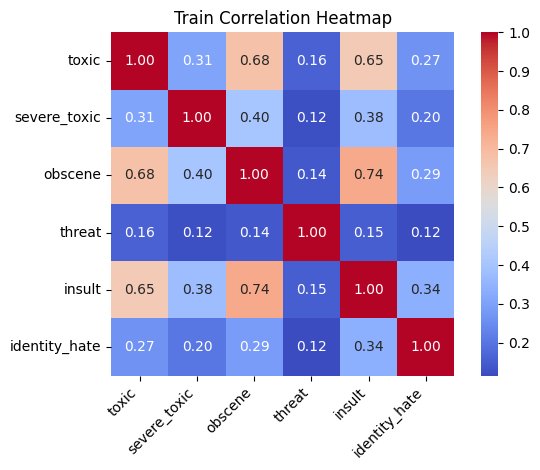

In [6]:
# Compute correlation matrix
train_corr = train_df[label_cols].corr()

# Create the heatmap
sns.heatmap(train_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.xticks(rotation=45, ha="right")
plt.title('Train Correlation Heatmap')
plt.tight_layout()
plt.show()

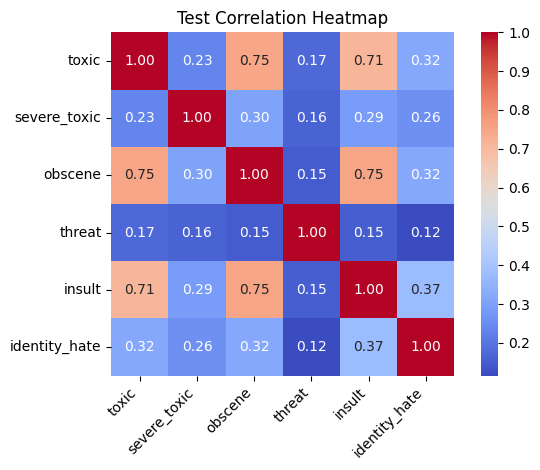

In [7]:
# Compute correlation matrix
test_corr = test_labels_df_usable[label_cols].corr()

# Create the heatmap
sns.heatmap(test_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.xticks(rotation=45, ha="right")
plt.title('Test Correlation Heatmap')
plt.tight_layout()
plt.show()

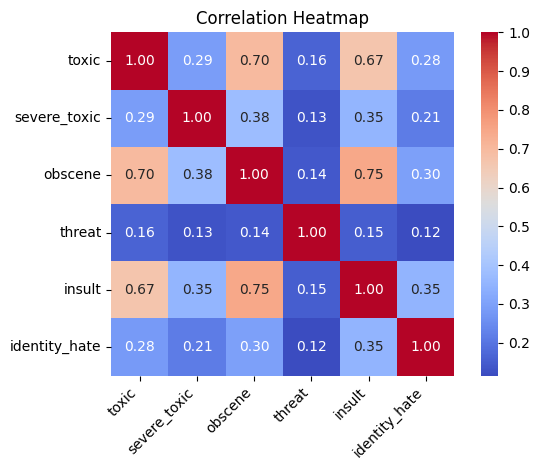

In [8]:
# Compute correlation matrix using both train and test data
combined_corr = pd.concat([train_df[label_cols], test_labels_df_usable[label_cols]], ignore_index=True).corr()

# Create the heatmap
sns.heatmap(combined_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.xticks(rotation=45, ha="right")
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

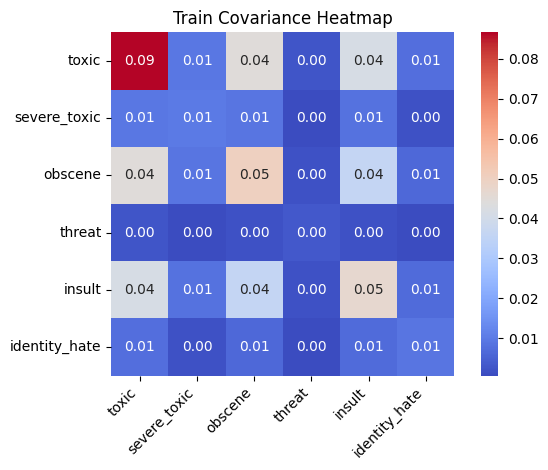

In [9]:
# Compute covariance matrix
train_cov = train_df[label_cols].cov()

# Create the heatmap
sns.heatmap(train_cov, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.xticks(rotation=45, ha="right")
plt.title('Train Covariance Heatmap')
plt.tight_layout()
plt.show()

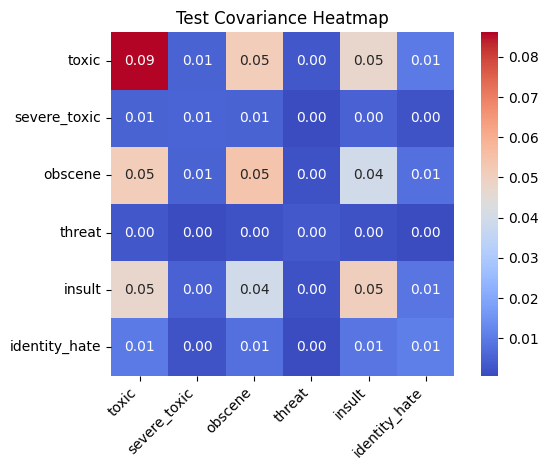

In [10]:
# Compute covariance matrix
test_cov = test_labels_df_usable[label_cols].cov()

# Create the heatmap
sns.heatmap(test_cov, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.xticks(rotation=45, ha="right")
plt.title('Test Covariance Heatmap')
plt.tight_layout()
plt.show()

(covariance isn't very useful in this context)

In [5]:
combined_X = pd.concat([train_df['comment_text'], test_df_usable['comment_text']], ignore_index=True).to_frame()

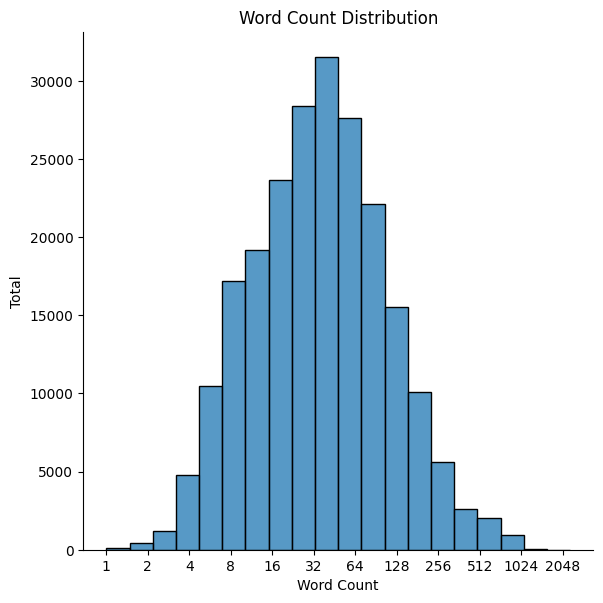

In [ ]:
# visualize distribution of comment text size and word count
combined_X['length'] = combined_X['comment_text'].str.len()
combined_X['word_count'] = [len(x.split()) for x in combined_X['comment_text'].tolist()]

ax = sns.displot(data=combined_X, x='word_count', log_scale=2, bins=20)
ax.axes[0, 0].set_xticks([2**i for i in range(12)])
ax.axes[0, 0].set_xticklabels([str(2**i) for i in range(12)])
plt.xlabel('Word Count')
plt.ylabel('Total')
plt.title('Word Count Distribution')
plt.tight_layout(pad=-3)
plt.show()

In [13]:
train_corr_mean = train_corr.mean().sort_values(ascending=False)
train_corr_mean

insult           0.542059
obscene          0.541475
toxic            0.509287
severe_toxic     0.402107
identity_hate    0.367890
threat           0.281165
dtype: float64

In [62]:
combined_corr_mean = combined_corr.mean().sort_values(ascending=False)
combined_corr_mean

insult           0.543709
obscene          0.542876
toxic            0.516034
severe_toxic     0.393228
identity_hate    0.375818
threat           0.283714
dtype: float64

In [14]:
# establish train and test datasets
train_X = train_df['comment_text']
train_y = train_df[label_cols]
test_X = test_df_usable['comment_text']
test_y = test_labels_df_usable[label_cols]

next steps:
1. feature engineering: utilize TF-IDF to get an embedding for each data point
2. model development: build a Classifier Chain the runs Logistic Regression  
  2.1. pass down probabilities to later classifiers (e.g. high confidence in toxic could indicate severe_toxic)
3. benchmark: evaluate performance and tune parameters

# PCA on Embeddings

In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

In [ ]:
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
X_embed = embed_model.encode(combined_X['comment_text'].tolist(), show_progress_bar=True, convert_to_numpy=True)

In [14]:
combined_y = pd.concat([train_df[label_cols], test_labels_df_usable[label_cols]], ignore_index=True)
has_label = (combined_y[label_cols].sum(axis=1) > 0).astype(int)

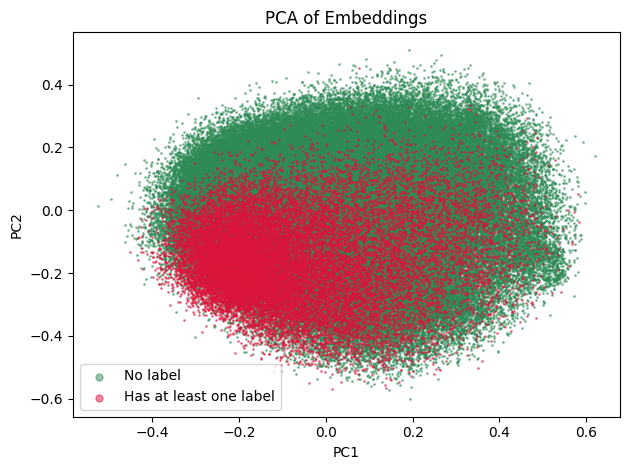

In [ ]:
pca = PCA(n_components=2)
X_embed_pca = pca.fit_transform(X_embed)

for val, label, color in [(0, "No label", "seagreen"), (1, "Has at least one label", "crimson")]:
    idx = (has_label == val)
    plt.scatter(X_embed_pca[idx, 0], X_embed_pca[idx, 1], s=1, c=color, label=label, alpha=0.5)

plt.legend(markerscale=5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Embeddings")
plt.tight_layout()
plt.show()

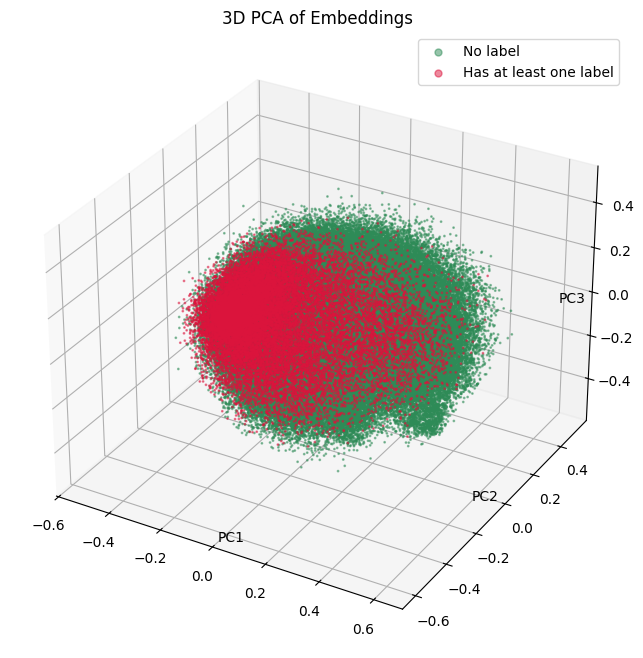

In [81]:
pca = PCA(n_components=3)
X_embed_pca = pca.fit_transform(X_embed)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

for val, label, color in [(0, "No label", "seagreen"), (1, "Has at least one label", "crimson")]:
    idx = (has_label == val)
    ax.scatter(X_embed_pca[idx, 0], X_embed_pca[idx, 1], X_embed_pca[idx, 2], s=1, c=color, label=label, alpha=0.5)

ax.legend(markerscale=5)
ax.set_xlabel("PC1", labelpad=-28)
ax.set_ylabel("PC2", labelpad=-30)
ax.set_zlabel("PC3", labelpad=-30)
ax.set_title("3D PCA of Embeddings")
plt.show()